In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [2]:
from ..exp import nb_anchors_loss_metrics
from ..exp import nb_databunch
from ..exp import nb_resnet_ssd

In [3]:
# export
from ..exp import nb_anchors_loss_metrics

In [4]:
from ..exp.nb_anchors_loss_metrics import get_y, idx_fromScoresHits

In [5]:
# export
import torch

In [6]:
# export
from torch import tensor

In [7]:
from fastai.basic_train import Learner

In [8]:
# export
from matplotlib import pyplot as plt

In [9]:
# export
from matplotlib import patches,patheffects

In [10]:
# export
from IPython.core import debugger as idb

In [11]:
from fastai.vision.image import Image

In [12]:
from functools import partial

In [13]:
# export
from math import ceil

# functions

## process_netout

In [14]:
# export
def process_netout(txys,thws,cats,confs,gaf):
    ts = torch.cat([txys,thws],dim=-1)
    boxs = gaf.t2b(ts,range(ts.shape[-2]))
    
    confs = torch.sigmoid(confs).squeeze(-1)
    prbs,cats = torch.softmax(cats,dim=-1).max(dim=-1)
#     cats = cats + 1
    
    return boxs,confs,cats,prbs

## nms

In [15]:
# export
def nms(boxes, cats, confs, ov_thres=0.2, despiteCat=True):
    '''
    despiteCat: despite category, 若=False，对相同类别做nms抑制；若=True，忽略类别，全局做nms
    '''
    keep = torch.zeros(confs.numel())
    count = 0

    if confs.numel()==0:
        # 如果无候选，返回
        return keep, count
 
    # 按 conf 从大至小排序
    idxs = confs.sort(0,descending=True)[1]
    
    while idxs.numel() >= 1:
        # 获取当前最置信的bbox
        idx_mc = idxs[0] # mc: most confident
        box_mc = boxes[idx_mc]
        cat_mc = cats[idx_mc]
        keep[count] = idx_mc
        count += 1
        
        # 除最置信之外的剩余bbox
        idxs = idxs[1:]
        if idxs.numel()==0: break
        boxes_r = boxes[idxs] # r: remain
        cats_r = cats[idxs]
        
        # 计算剩余与最大的IoU 
        IoU = nb_anchors_loss_metrics.iou(box_mc.reshape(-1,4),boxes_r.reshape(-1,4)).squeeze()
        
        # 选择保留
        if despiteCat:
            # 若不考虑类别，则保留 IoU<=overlap 的
            idxs = idxs[IoU<=ov_thres]
        else:
            # 若考虑类别，则保留 IoU<=overlap 或 类别不同 的
            idxs = idxs[(IoU<=ov_thres) | (cats_r!=cat_mc)]
        
    return keep, count

## idx_from_gt

In [16]:
def idx_from_gt(*gt_batch, gaf):
    loss = 0
    cnt = 0
    for gt_bboxs in gt_batch[0]:
        keep = get_y(gt_bboxs)
        if keep.numel()==0: continue
          
        gt_bboxs = gt_bboxs[keep]
        
        gt_bboxs = (gt_bboxs + 1) / 2
        
        scores,hits = gaf.get_scores_hits(gt_bboxs)
        idx = idx_fromScoresHits(scores,hits)
        
        return idx

## netout2pred

In [17]:
# export
def netouts2preds(batchOut,gaf,composeConfPrb=True,filt_thres=0.9,ov_thres=0.2,despiteCat=True):
    '''
    处理一个batch
    '''
    batch_boxs = []
    batch_confs = []
    batch_cats = []
    batch_prbs = []
    batch_f1s = []
    
    for txys,confs,cats,thws in zip(batchOut[0].detach(),batchOut[1].detach(),batchOut[2].detach(),batchOut[3].detach()):
        boxs,confs,cats,prbs = process_netout(txys,thws,cats,confs,gaf)
        
        f1s = 2*confs*prbs/(confs+prbs)
        if composeConfPrb:
            filt = torch.where(f1s>filt_thres)
        else:
            filt = torch.where(confs>filt_thres)
            
        boxs = boxs[filt]
        confs = confs[filt]
        cats = cats[filt]
        prbs = prbs[filt]
        f1s = f1s[filt]
        
        if composeConfPrb:
            keep,cnt = nms(boxs, cats, f1s, ov_thres=ov_thres, despiteCat=True)
        else:
            keep,cnt = nms(boxs, cats, confs, ov_thres=ov_thres, despiteCat=True)
            
        keep = keep[:cnt].long()
        
        boxs = boxs[keep]
        confs = confs[keep]
        cats = cats[keep]
        prbs = prbs[keep]
        f1s = f1s[keep]
        
        batch_boxs += [boxs]
        batch_confs += [confs]
        batch_cats += [cats]
        batch_prbs += [prbs]
        batch_f1s += [f1s]
        
    return batch_boxs, batch_confs, batch_cats, batch_prbs, batch_f1s

## draw

### basic

In [18]:
# export
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='red'), patheffects.Normal()])

In [19]:
# export
def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 4)

In [20]:
# export
def draw_rect(ax, b, color='red',lw=2):
    x = b[1]
    y = b[0]
    w = b[3]-b[1]
    h = b[2]-b[0]
    
    patch = ax.add_patch(patches.Rectangle((x,y), w, h, fill=False, edgecolor=color, lw=lw))
    draw_outline(patch, lw=lw)

### show_gt

In [40]:
def show_gt(x,y):
    img = data.denorm(x)[0].permute(1,2,0)

    _,ax = plt.subplots(1,1,figsize=(15,15))
    ax.imshow(img)
    
    for bb,cat in zip(y[0][0],y[1][0]):
        bb = (bb+1)/2*776
        draw_rect(ax,bb,lw=1)
        
        cat = cat-1
        clas = classes[cat]
        draw_text(ax,bb[[3,0]],clas[:3],sz=10)

### show_gt_anchors

In [22]:
def show_gt_anchors(x,y,n=10):
    '根据ground truch找到负责idxs，绘制这些idxs对应的anchor'
    _,ax = plt.subplots(1,1,figsize=(20,20))
    img = data.denorm(x)[0].permute(1,2,0)
    ax.imshow(img)
    
    idxs = idx_from_gt(*y,gaf=gaf)
    for idx in idxs:
        gv = gvs[idx]*x.shape[-1]
        draw_rect(ax,gv,lw=1,color='g')
        
        cx = gv[[0,2]].mean()
        cy = gv[[1,3]].mean()
        
        av = avs[idx]*x.shape[-1]
        av = av+tensor([cx,cy,cx,cy])
        draw_rect(ax,av,lw=1)
        

        draw_text(ax,av[[3,0]],f'{idx}',sz=10)
    return idxs

### show_top_pred

In [23]:
def show_top_pred(x,netOut,n=10):
    '''
    根据模型输出，处理得到boxs和confs，按照confs从大到小排序，绘制前n个的box.
    x的作用仅是为绘制原图；
    '''
    _,ax = plt.subplots(1,1,figsize=(20,20))
    img = data.denorm(x)[0].permute(1,2,0)
    ax.imshow(img)
    
    txys,confs,cats,thws = netOut[0][0].detach(),netOut[1][0].detach(),netOut[2][0].detach(),netOut[3][0].detach() 
    boxs,confs,cats,prbs = process_netout(txys,thws,cats,confs,gaf)
    
    top_idx = confs.sort(descending=True)[1]
    for idx in top_idx[:n]:
        bb = boxs[idx]*x.shape[-1]
        draw_rect(ax,bb,lw=1)

        clas = classes[cats[idx]]
        conf = confs[idx]
        info = '{}_{}_{:.2f}'.format(idx,clas[:3],conf*100)
        draw_text(ax,bb[[3,0]],info,sz=10)
    return top_idx[:n]

### show_batch_pred

In [24]:
# export
def show_batch_pred(batch_x,
                    batch_boxs,
                    batch_cats,
                    batch_scores,
                    classes):
    '''
    输入原图，nms处理后的模型预测，绘制这些预测。以batch为单位绘制。
    ------------------------------
    参数：
    -- batch_x：一个batch的图片，像素值应在[0,1]或[0,255]范围内，图片 shape 应为 height * width * channel
    -- batch_boxs：目标框，每个框表示为（左上角x，左上角y，右下角x，右下角y）
    -- batch_cats：类别，每个类别以整数表示，该整数作为classes的索引
    -- batch_scores：目标得分，可以是confidence，也可以是f1得分(=conf*prb/(conf+prb))，你传入什么就打印什么
    -- classes：一个list，元素为字符串，是各类别的名称，其顺序应与batch_cats对应
    '''
    bs = len(batch_cats)
    rows = ceil(bs/2)
    
    _,axs = plt.subplots(rows,2,figsize=(20,10*rows))
    axs = axs.flatten()
    
    for i in range(bs):
        ax = axs[i]
        
        x = batch_x[i]
        x = x.permute(1,2,0)
        ax.imshow(x)
        
        h,w = x.shape[:2]
        img_s = tensor([h,w,h,w]).to(batch_boxs[0].device)
    
        boxs = batch_boxs[i]
        cats = batch_cats[i]
        scores = batch_scores[i]
            
        for j in range(len(cats)):
            box = boxs[j]*img_s
            draw_rect(ax,box,lw=1)
            
            cat = cats[j]
            clas = classes[cat][:3]
            score = scores[j]
            info = '{}_{:.2f}'.format(clas,score*100) 
            draw_text(ax,box[[3,0]],info,sz=8)

### plot_all_grids

In [25]:
def plot_all_grids(gvs):
    _,axs = plt.subplots(3,1,figsize=(30,90))
    axs = axs.flatten()
    
    for i in range(49*49):
        gv = gvs[i*4]
        draw_rect(axs[0],gv)
        bx=gv[1]
        by=0.5*gv[0]+0.5*gv[2]
        draw_text(axs[0],(bx,by),str(i*4),sz=10)
        
    for i in range(49*49,49*49+25*25):
        gv = gvs[i*4]
        draw_rect(axs[1],gv)
        bx=gv[1]
        by=0.5*gv[0]+0.5*gv[2]
        draw_text(axs[1],(bx,by),str(i*4),sz=10)
        
    for i in range(49*49+25*25, 49*49+25*25+13*13):
        gv = gvs[i*4]
        draw_rect(axs[2],gv)
        bx=gv[1]
        by=0.5*gv[0]+0.5*gv[2]
        draw_text(axs[2],(bx,by),str(i*4),sz=10)

# test

## 准备好learner

In [26]:
device = torch.device('cuda')

In [27]:
data = nb_databunch.get_databunch(data_root='./data/ds_20200428',bs=64,device=device,cache=False) 

In [28]:
gvs,_,_,avs,_,_ = nb_anchors_loss_metrics.get_ga666()
gaf = nb_anchors_loss_metrics.GridAnchor_Funcs(gvs,avs,device)

In [29]:
model = nb_resnet_ssd.get_resnet18_1ssd_2()

In [30]:
learn = Learner(data,model)

In [31]:
with open('./run_log/yanke/run_0.pth','rb') as f:
    learn.load(f)

In [32]:
# 把模型放到device上，如果使用GPU，则设置使用哪几个GPU
if hasattr(learn.model, "module"): 
    learn.model = model.module

learn.model.to(device);

if device.type=='cuda':
    learn.model = torch.nn.DataParallel(model,device_ids=[0,1,2,3])

In [33]:
learn.model.eval();

## 验证模型的整体表现

In [34]:
# metrics = [partial(nb_anchors_loss_metrics.clas_L,gaf=gaf),
#            partial(nb_anchors_loss_metrics.cent_L,gaf=gaf),
#            partial(nb_anchors_loss_metrics.hw_L,gaf=gaf),
#            partial(nb_anchors_loss_metrics.pConf_L,gaf=gaf),
#            partial(nb_anchors_loss_metrics.nConf_L,gaf=gaf),
#            partial(nb_anchors_loss_metrics.clas_acc,gaf=gaf),
#            partial(nb_anchors_loss_metrics.cent_d,gaf=gaf),
#            partial(nb_anchors_loss_metrics.hw_r,gaf=gaf)]

# learn.loss_func = partial(nb_anchors_loss_metrics.yolo_L, gaf=gaf)

# res = learn.validate(data.train_dl,metrics=metrics)

# res

## 观察

In [35]:
classes = data.train_ds.y.classes[1:]
classes

['c10_duanluqi',
 'c11_sanxiangbyq',
 'c12_dongrongshidyhgq',
 'c13_danxiangbyq',
 'c14_danciranzudlhgq',
 'c15_duojikaiguan',
 'c16_diankangqi',
 'c1_tiaoya',
 'c2_dianyahgq',
 'c3_3gongweiglkg',
 'c4_kuaisujdkg',
 'c5_daidianxianshiqi',
 'c6_rongduanqi',
 'c7_bileiqi',
 'c8_dianliuhgq',
 'c9_danxiangdyhgq']

In [42]:
dl = data.train_dl

dl.batch_size=1

dl_list = list(iter(dl))

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.17 GiB total capacity; 9.22 GiB already allocated; 8.81 MiB free; 10.90 GiB reserved in total by PyTorch)

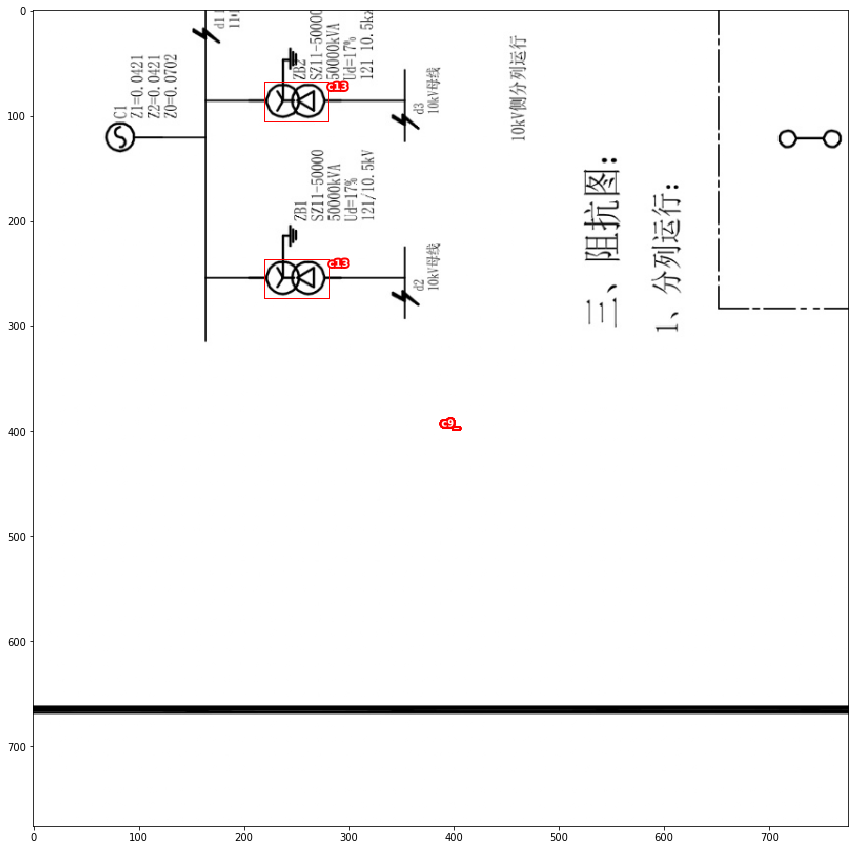

In [41]:
x,y = dl_list[0]
show_gt(x,y)

tensor([59559, 49797, 37568, 46316, 33517, 10271, 13742, 10304, 10863],
       device='cuda:0')

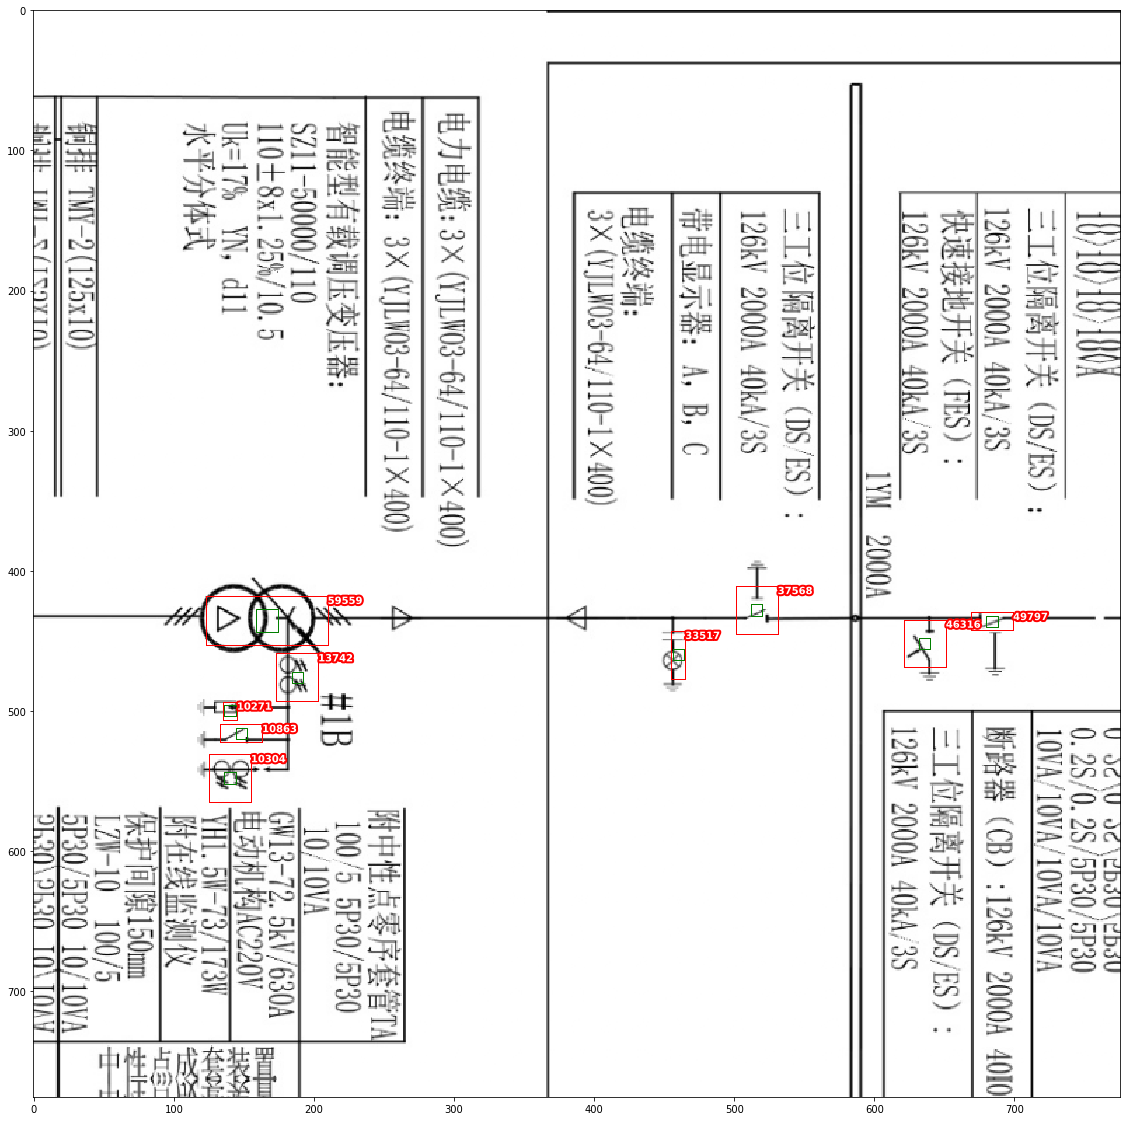

In [39]:
show_gt_anchors(x,y)

In [51]:
netOut = learn.model(x)

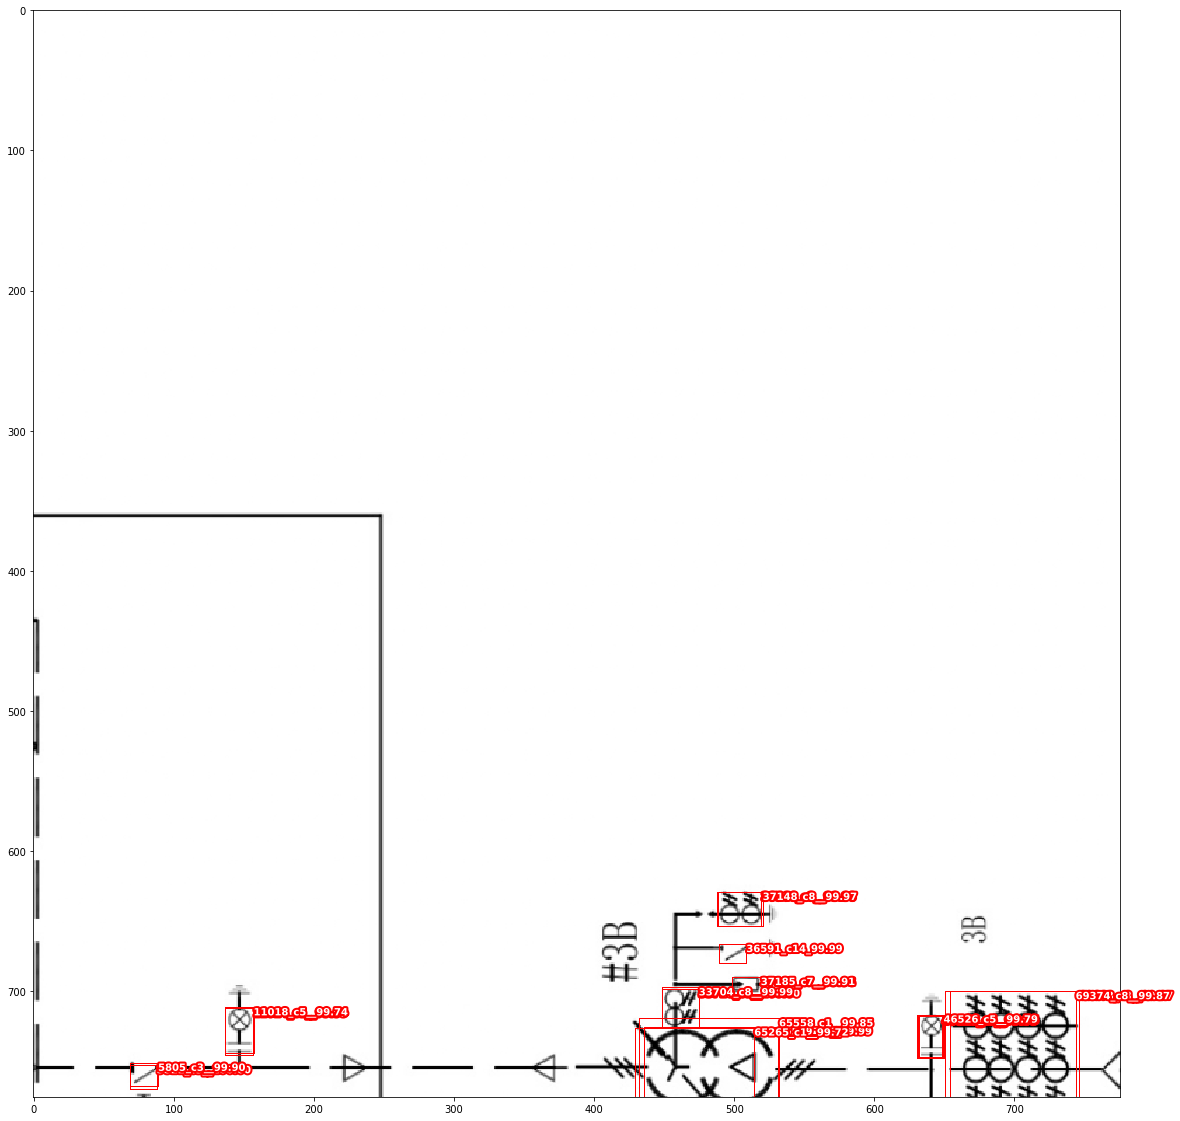

In [52]:
top_idx=show_top_pred(x,netOut,20)

## interpert

In [44]:
classes = data.train_ds.y.classes[1:]
classes

['c10_duanluqi',
 'c11_sanxiangbyq',
 'c12_dongrongshidyhgq',
 'c13_danxiangbyq',
 'c14_danciranzudlhgq',
 'c15_duojikaiguan',
 'c16_diankangqi',
 'c1_tiaoya',
 'c2_dianyahgq',
 'c3_3gongweiglkg',
 'c4_kuaisujdkg',
 'c5_daidianxianshiqi',
 'c6_rongduanqi',
 'c7_bileiqi',
 'c8_dianliuhgq',
 'c9_danxiangdyhgq']

In [45]:
dl = data.valid_dl

dl.batch_size=32

dl_list = list(iter(dl))

In [46]:
x,y = dl_list[2]

In [47]:
batch_x = [data.denorm(xx) for xx in x]

In [48]:
netOut = learn.model(x)

In [49]:
b_boxs, b_confs, b_cats, b_prbs, b_f1s = netouts2preds(batchOut=netOut,
                                                       gaf=gaf,
                                                       composeConfPrb=True,
                                                       filt_thres=0.997,
                                                       ov_thres=0.2,
                                                       despiteCat=True)

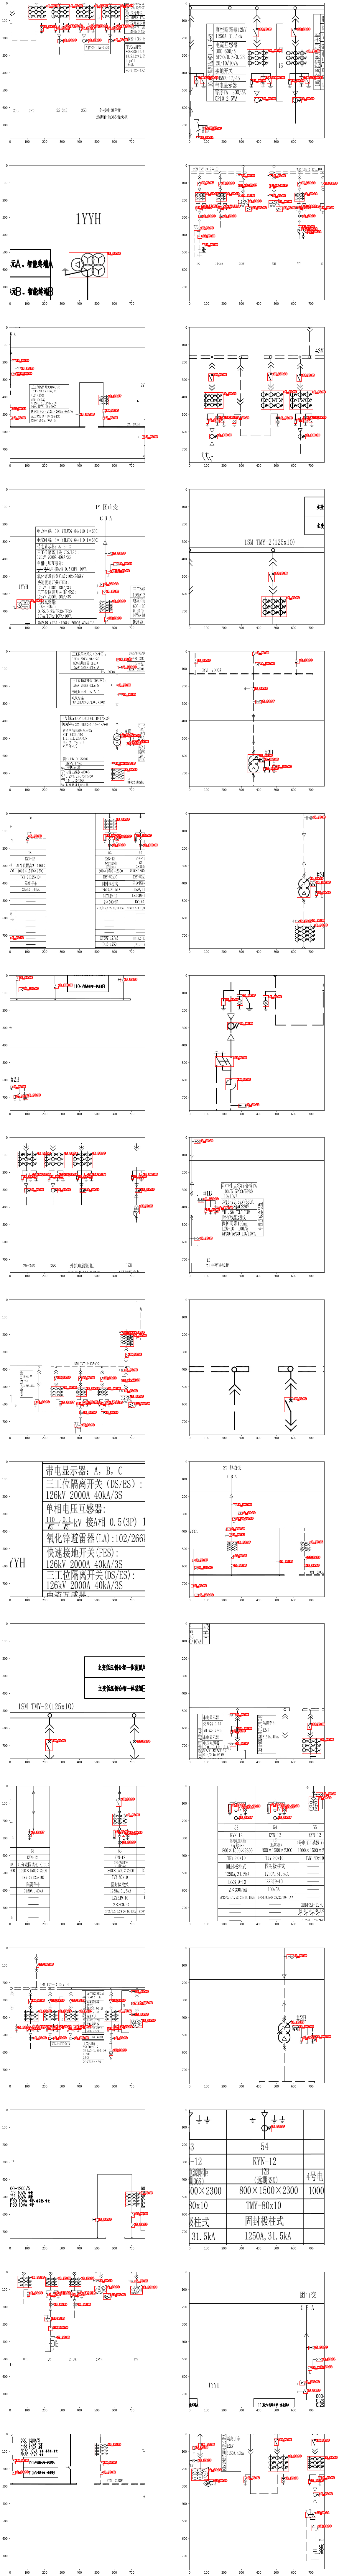

In [50]:
show_batch_pred(batch_x,
                b_boxs,
                b_cats,
                b_f1s,
                classes=classes)

# export

In [1]:
!python ../../notebook2script.py --fname 'interpretation.ipynb' --outputDir '../exp/'

Converted interpretation.ipynb to ../exp/interpretation.py
